<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/NEMO_Equation_AAI_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "nvidia-nat[langchain]" langchain-nvidia-ai-endpoints sympy -q

In [3]:
!nat --version

nat, version 1.3.1


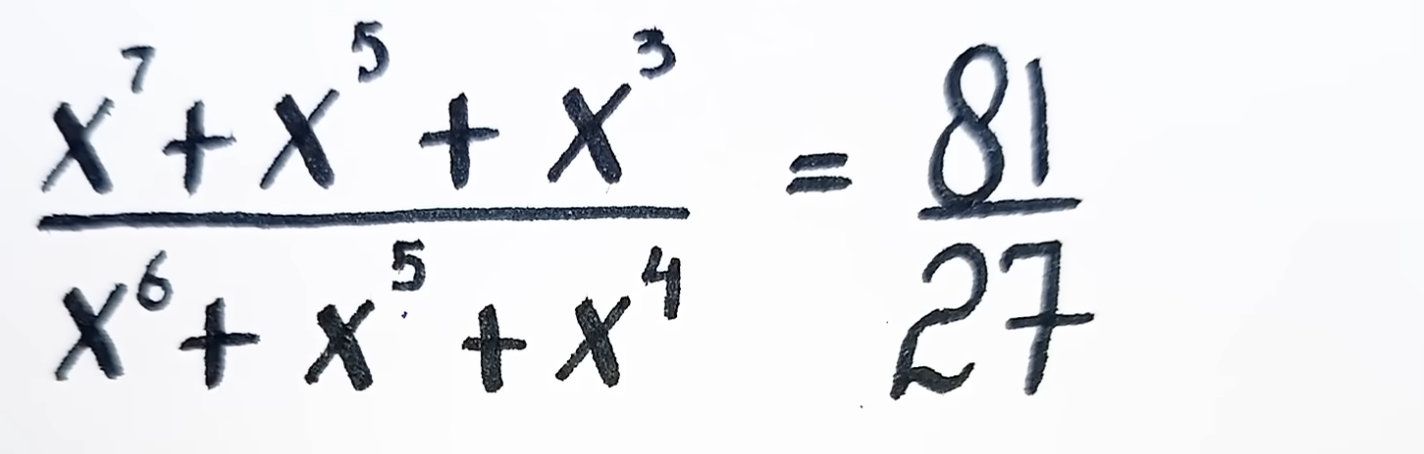

--- INITIALIZING NVIDIA NAT WORKFLOW ---
STEP 1 LOG | Action: solve_equation | Tool Output: ['2 - sqrt(3)', 'sqrt(3) + 2']
STEP 2 LOG | Action: calculate_decimal | Tool Output: 0.267949192431123
STEP 2 LOG | Action: calculate_decimal | Tool Output: 3.732050807568880
-- RUNNING WORKFLOW ---

FINAL OUTPUT:
The equation extracted is:

\[
\frac{x^7 + x^5 + x^3}{x^6 + x^5 + x^4} = \frac{81}{27}
\]

The symbolic solutions for \( x \) are \( 2 - \sqrt{3} \) and \( \sqrt{3} + 2 \).

The decimal values are:
- \( 2 - \sqrt{3} \approx 0.2679 \)
- \( \sqrt{3} + 2 \approx 3.7321 \)


In [5]:
import os
import sympy
import base64
import asyncio
from typing import Dict, Any, List
from google.colab import userdata
from IPython.display import Image, display

# 1. IMPORTS & SETUP
from nat.builder.workflow_builder import WorkflowBuilder
from nat.cli.register_workflow import register_function
from nat.builder.function_info import FunctionInfo
from nat.data_models.function import FunctionBaseConfig
from pydantic import Field

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage

# --- AUTHENTICATION ---
os.environ["NVIDIA_API_KEY"] = userdata.get("NVIDIA_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
FILE_PATH = "/content/drive/MyDrive/data/equation.png"

# 2. DEFINE TOOLS (With corrected logic for decimal calculation)
@tool
def solve_equation(equation_str: str) -> List[str]:
    """Solves an algebraic equation symbolically. Input: 'lhs = rhs'."""
    x = sympy.symbols('x')
    try:
        if "=" not in equation_str:
            return ["Error: Equation must contain an '=' sign."]
        lhs_s, rhs_s = equation_str.split('=')
        eq = sympy.Eq(sympy.simplify(lhs_s), sympy.simplify(rhs_s))
        solutions = sympy.solve(eq, x)
        # Return exact symbolic strings
        return [str(s) for s in solutions]
    except Exception as e:
        return [f"Error: {str(e)}"]

@tool
def calculate_decimal(expression: str) -> str:
    """Calculates the numerical decimal value of a symbolic expression.
    Example: '2 - sqrt(3)' -> '0.2679...'
    """
    try:
        # We simplify and then evaluate to ensure precision
        res = sympy.simplify(expression).evalf()
        return f"{res:.15f}"
    except Exception as e:
        return f"Error: {str(e)}"

# 3. HELPER: IMAGE ENCODING
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 4. THE AGENTIC EXECUTION LOOP
class MathVisionConfig(FunctionBaseConfig, name="math_vision_agent"):
    model_name: str = Field(default="gpt-4o")
    temperature: float = Field(default=0.0)

@register_function(config_type=MathVisionConfig)
async def run_math_workflow(config: MathVisionConfig, builder: Any):
    llm = ChatOpenAI(model=config.model_name, temperature=config.temperature)
    tools = [solve_equation, calculate_decimal]
    llm_with_tools = llm.bind_tools(tools)

    base64_image = encode_image(FILE_PATH)

    # Initial Prompt: Explicit instructions to avoid hallucinations
    messages = [
        HumanMessage(content=[
            {
                "type": "text",
                "text": "1. Extract the equation from the image.\n"
                        "2. Solve for x symbolically using solve_equation.\n"
                        "3. For EVERY symbolic root found, pass that EXACT string to calculate_decimal.\n"
                        "4. Do not perform mental math; rely only on tool outputs."
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{base64_image}"}
            }
        ])
    ]

    # Iterative Loop
    for i in range(10):
        response = await llm_with_tools.ainvoke(messages)
        messages.append(response)

        if not response.tool_calls:
            break

        for tool_call in response.tool_calls:
            tool_name = tool_call["name"]
            tool_map = {"solve_equation": solve_equation, "calculate_decimal": calculate_decimal}
            tool_func = tool_map[tool_name]

            # Execute tool
            output = tool_func.invoke(tool_call["args"])

            # Corrected Log: Ensures we see exactly what the tool returned
            print(f"STEP {i+1} LOG | Action: {tool_name} | Tool Output: {output}")

            messages.append(ToolMessage(content=str(output), tool_call_id=tool_call["id"]))

    async def _final_response(param: Any = None) -> str:
        return messages[-1].content

    yield FunctionInfo.from_fn(_final_response)

# 5. EXECUTION
async def main():
    if not os.path.exists(FILE_PATH):
        print("ERROR: Image not found.")
        return

    display(Image(filename=FILE_PATH, width=400))
    print("--- INITIALIZING NVIDIA NAT WORKFLOW ---")

    builder = WorkflowBuilder()
    workflow_config = MathVisionConfig()

    async with run_math_workflow(config=workflow_config, builder=builder) as final_result_info:
        print("-- RUNNING WORKFLOW ---")
        result = await final_result_info.single_fn()

    print(f"\nFINAL OUTPUT:\n{result}")

await main()